<h2> Team Name: <em>Order of the Phoenix</em> </h2>
<br>

<div style="background:lightblue;">
    <h3> Team Members:</h3>
    <br>
    <li> Salar Hosseini Shamchi</li>
    <li> Mohammad Hosseinzadeh</li>
    <li> Ahmad Ahmadi</li>
    </div>
    

Importing all the necessary packages:

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from sklearn.metrics import r2_score
from numpy.random import seed
import tensorflow as tf
import os
import shutil

Setting a seed value for consistent results:

In [16]:
seed_value = 5
seed(seed_value)
tf.random.set_seed(seed_value)

Loading CSV files:

In [17]:
train_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_train.csv', index_col='subscriber_ecid')
train_file.insert(train_file.shape[1] - 1, 'data_usage_volume', train_file.pop('data_usage_volume'))

week1_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_test_week1_with_target.csv', index_col='subscriber_ecid')
week1_file.insert(week1_file.shape[1] - 1, 'data_usage_volume', week1_file.pop('data_usage_volume'))

week2_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_test_week2.csv', index_col='subscriber_ecid')
week2_file.insert(week2_file.shape[1], 'data_usage_volume', np.zeros(week2_file.shape[0]))

week3_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_test_week3.csv', index_col='subscriber_ecid')

Preprocessing the data:

In [18]:
people = np.unique(week3_file.index)
total_days = 76
x = []
y = []
for person in people:
    person_train = train_file.loc[person]
    person_week1 = week1_file.loc[person]
    person_data = pd.concat([person_train, person_week1]).drop('day', axis=1).values
    data_dim = person_data.shape
    for i in range(data_dim[0]):
        for j in range(data_dim[1]):
            if np.isnan(person_data[i, j]):
                person_data[i, j] = np.nanmean(person_data[:, j])

    for i in range(person_data.shape[0] - 5):
        if i == 0:
            sequence = person_data.copy()
        else:
            sequence = person_data.copy()[:-i]
        output = sequence[-1, -1]
        sequence[:, -1] = np.roll(sequence[:, -1], 1, axis=0)
        pad = np.zeros([total_days - sequence.shape[0], sequence.shape[1]])
        sequence = np.vstack((pad, sequence[1:]))
        x.append(sequence)
        y.append(output)

x = np.asarray(x, dtype=np.float64)
y = np.asarray(y, dtype=np.float64)

Splitting the data to train and validation sets, and normalizing:

In [19]:
if os.path.exists('./My Model'):
    shutil.rmtree('./My Model')
os.makedirs('./My Model')

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=7)

np.save('./My Model/x_train.npy', x_train)
np.save('./My Model/x_val.npy', x_val)
np.save('./My Model/y_train.npy', y_train)
np.save('./My Model/y_val.npy', y_val)

x_min = x_train.min(axis=(0, 1))
x_max = x_train.max(axis=(0, 1))
x_indices = np.where(x_min == x_max)[0]
for ind in x_indices:
    x_max[ind] += 1

np.save('./My Model/x_min.npy', x_min)
np.save('./My Model/x_max.npy', x_max)

x_train = (x_train - x_min) / (x_max - x_min)
x_val = (x_val - x_min) / (x_max - x_min)

Building the model:

In [20]:
inp_layer = Input(shape=(None, x_train.shape[2]))
layer = LSTM(16, return_sequences=True)(inp_layer)
layer = LSTM(16, return_sequences=False)(layer)
out_layer = Dense(1, activation='linear')(layer)

my_model = Model(inp_layer, out_layer)
my_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 32)]        0         
                                                                 
 lstm_2 (LSTM)               (None, None, 16)          3136      
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,265
Trainable params: 5,265
Non-trainable params: 0
_________________________________________________________________


Training the model:

In [21]:
lr = CosineDecayRestarts(initial_learning_rate=0.001, first_decay_steps=20)
my_model.compile(optimizer=Adam(lr), loss=MSE)

cb = ModelCheckpoint('./Checkpoints/checkpoint', monitor='val_loss', save_best_only=True, save_weights_only=True)
results = my_model.fit(x_train, y_train, batch_size=512, epochs=2000, callbacks=[cb], validation_data=(x_val, y_val))
my_model.load_weights('./Checkpoints/checkpoint')
my_model.save('./My Model')

Epoch 1/2000
12/12 [==============================] - 8s 154ms/step - loss: 9.7289 - val_loss: 46.5738
Epoch 2/2000
12/12 [==============================] - 0s 35ms/step - loss: 8.9460 - val_loss: 45.9471
Epoch 3/2000
12/12 [==============================] - 0s 36ms/step - loss: 8.6825 - val_loss: 45.5183
Epoch 4/2000
12/12 [==============================] - 0s 34ms/step - loss: 8.5250 - val_loss: 45.4448
Epoch 5/2000
12/12 [==============================] - 0s 34ms/step - loss: 8.4257 - val_loss: 45.4299
Epoch 6/2000
12/12 [==============================] - 0s 36ms/step - loss: 8.2056 - val_loss: 44.9222
Epoch 7/2000
12/12 [==============================] - 0s 34ms/step - loss: 7.7395 - val_loss: 44.7318
Epoch 8/2000
12/12 [==============================] - 0s 34ms/step - loss: 7.4325 - val_loss: 44.3667
Epoch 9/2000
12/12 [==============================] - 0s 33ms/step - loss: 7.0847 - val_loss: 43.9860
Epoch 10/2000
12/12 [==============================] - 0s 33ms/step - loss: 6.927

12/12 [==============================] - 0s 29ms/step - loss: 4.8978 - val_loss: 38.4710
Epoch 81/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.8736 - val_loss: 38.4843
Epoch 82/2000
12/12 [==============================] - 0s 33ms/step - loss: 4.8693 - val_loss: 38.3034
Epoch 83/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.8477 - val_loss: 38.4095
Epoch 84/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.8422 - val_loss: 38.3695
Epoch 85/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.8290 - val_loss: 38.4034
Epoch 86/2000
12/12 [==============================] - 0s 34ms/step - loss: 4.8403 - val_loss: 38.2957
Epoch 87/2000
12/12 [==============================] - 0s 31ms/step - loss: 4.8389 - val_loss: 38.3934
Epoch 88/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.8239 - val_loss: 38.3509
Epoch 89/2000
12/12 [==============================] - 0s 34ms/step - loss: 4.8123 - va

12/12 [==============================] - 0s 29ms/step - loss: 4.3551 - val_loss: 37.3464
Epoch 160/2000
12/12 [==============================] - 0s 34ms/step - loss: 4.3529 - val_loss: 37.2900
Epoch 161/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.3416 - val_loss: 37.3105
Epoch 162/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.3374 - val_loss: 37.3260
Epoch 163/2000
12/12 [==============================] - 0s 34ms/step - loss: 4.3226 - val_loss: 37.1365
Epoch 164/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.3148 - val_loss: 37.1704
Epoch 165/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.3109 - val_loss: 37.1395
Epoch 166/2000
12/12 [==============================] - 0s 28ms/step - loss: 4.3083 - val_loss: 37.2492
Epoch 167/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.3098 - val_loss: 37.1426
Epoch 168/2000
12/12 [==============================] - 0s 29ms/step - loss: 4.

Epoch 238/2000
12/12 [==============================] - 0s 33ms/step - loss: 4.0245 - val_loss: 36.8214
Epoch 239/2000
12/12 [==============================] - 0s 36ms/step - loss: 4.0793 - val_loss: 36.8010
Epoch 240/2000
12/12 [==============================] - 0s 28ms/step - loss: 4.0115 - val_loss: 37.1660
Epoch 241/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.9914 - val_loss: 36.9013
Epoch 242/2000
12/12 [==============================] - 0s 28ms/step - loss: 4.0325 - val_loss: 37.0507
Epoch 243/2000
12/12 [==============================] - 0s 28ms/step - loss: 4.0033 - val_loss: 36.8205
Epoch 244/2000
12/12 [==============================] - 0s 33ms/step - loss: 3.9620 - val_loss: 36.7749
Epoch 245/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.9486 - val_loss: 36.9120
Epoch 246/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.9505 - val_loss: 36.9020
Epoch 247/2000
12/12 [==============================] - 0s 34ms/

Epoch 317/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.5503 - val_loss: 36.1822
Epoch 318/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.5274 - val_loss: 36.1626
Epoch 319/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.5296 - val_loss: 36.2038
Epoch 320/2000
12/12 [==============================] - 0s 30ms/step - loss: 3.5416 - val_loss: 36.1260
Epoch 321/2000
12/12 [==============================] - 0s 35ms/step - loss: 3.5267 - val_loss: 36.0898
Epoch 322/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.5241 - val_loss: 36.1323
Epoch 323/2000
12/12 [==============================] - 0s 30ms/step - loss: 3.5023 - val_loss: 36.0949
Epoch 324/2000
12/12 [==============================] - 0s 34ms/step - loss: 3.5152 - val_loss: 36.0868
Epoch 325/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.5247 - val_loss: 36.2068
Epoch 326/2000
12/12 [==============================] - 0s 29ms/

Epoch 396/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.3675 - val_loss: 36.0131
Epoch 397/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.3676 - val_loss: 36.0268
Epoch 398/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.3668 - val_loss: 36.0202
Epoch 399/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.3678 - val_loss: 36.0193
Epoch 400/2000
12/12 [==============================] - 0s 30ms/step - loss: 3.3673 - val_loss: 36.0154
Epoch 401/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.3669 - val_loss: 36.0261
Epoch 402/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.3656 - val_loss: 36.0296
Epoch 403/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.3652 - val_loss: 36.0309
Epoch 404/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.3646 - val_loss: 36.0271
Epoch 405/2000
12/12 [==============================] - 0s 29ms/

Epoch 475/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.2538 - val_loss: 35.6629
Epoch 476/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.2662 - val_loss: 36.0813
Epoch 477/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.2613 - val_loss: 35.7832
Epoch 478/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.3009 - val_loss: 35.7423
Epoch 479/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.3115 - val_loss: 35.9735
Epoch 480/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.2618 - val_loss: 35.8911
Epoch 481/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.2671 - val_loss: 35.7686
Epoch 482/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.2510 - val_loss: 35.9189
Epoch 483/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.2434 - val_loss: 35.7348
Epoch 484/2000
12/12 [==============================] - 0s 29ms/

Epoch 554/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.0661 - val_loss: 35.4708
Epoch 555/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.0493 - val_loss: 35.4685
Epoch 556/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.0400 - val_loss: 35.4105
Epoch 557/2000
12/12 [==============================] - 0s 28ms/step - loss: 3.0592 - val_loss: 35.5007
Epoch 558/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.0692 - val_loss: 35.5467
Epoch 559/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.0440 - val_loss: 35.7638
Epoch 560/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.0532 - val_loss: 35.6007
Epoch 561/2000
12/12 [==============================] - 0s 29ms/step - loss: 3.0827 - val_loss: 35.5594
Epoch 562/2000
12/12 [==============================] - 0s 34ms/step - loss: 3.0425 - val_loss: 35.3128
Epoch 563/2000
12/12 [==============================] - 0s 29ms/

Epoch 633/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.9024 - val_loss: 35.5781
Epoch 634/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.8836 - val_loss: 35.5090
Epoch 635/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.8727 - val_loss: 35.4894
Epoch 636/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.8873 - val_loss: 35.3963
Epoch 637/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.9176 - val_loss: 35.6289
Epoch 638/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.8897 - val_loss: 35.3715
Epoch 639/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.8825 - val_loss: 35.6817
Epoch 640/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.8996 - val_loss: 35.4140
Epoch 641/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.8620 - val_loss: 35.4192
Epoch 642/2000
12/12 [==============================] - 0s 28ms/

Epoch 712/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7802 - val_loss: 35.5060
Epoch 713/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7701 - val_loss: 35.4261
Epoch 714/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7799 - val_loss: 35.4259
Epoch 715/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7702 - val_loss: 35.6258
Epoch 716/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7728 - val_loss: 35.5528
Epoch 717/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7697 - val_loss: 35.4993
Epoch 718/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7779 - val_loss: 35.3887
Epoch 719/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.7856 - val_loss: 35.4267
Epoch 720/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7623 - val_loss: 35.6412
Epoch 721/2000
12/12 [==============================] - 0s 30ms/

Epoch 791/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7256 - val_loss: 35.4853
Epoch 792/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7266 - val_loss: 35.4900
Epoch 793/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7249 - val_loss: 35.4647
Epoch 794/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.7251 - val_loss: 35.4682
Epoch 795/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7228 - val_loss: 35.4817
Epoch 796/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7230 - val_loss: 35.4572
Epoch 797/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7229 - val_loss: 35.4652
Epoch 798/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.7221 - val_loss: 35.4596
Epoch 799/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7234 - val_loss: 35.4564
Epoch 800/2000
12/12 [==============================] - 0s 29ms/

Epoch 870/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.8221 - val_loss: 35.6634
Epoch 871/2000
12/12 [==============================] - 0s 35ms/step - loss: 2.8231 - val_loss: 34.8195
Epoch 872/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.8475 - val_loss: 35.3576
Epoch 873/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.9103 - val_loss: 35.1885
Epoch 874/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.8657 - val_loss: 35.4350
Epoch 875/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.8541 - val_loss: 35.0214
Epoch 876/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.8158 - val_loss: 35.3224
Epoch 877/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.8170 - val_loss: 35.6394
Epoch 878/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.8234 - val_loss: 35.2423
Epoch 879/2000
12/12 [==============================] - 0s 30ms/

Epoch 949/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.7500 - val_loss: 35.8202
Epoch 950/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.6678 - val_loss: 35.6690
Epoch 951/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.6613 - val_loss: 35.1851
Epoch 952/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.6346 - val_loss: 35.4847
Epoch 953/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.6483 - val_loss: 35.6774
Epoch 954/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.6025 - val_loss: 35.6618
Epoch 955/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.6078 - val_loss: 35.3326
Epoch 956/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.6276 - val_loss: 35.5745
Epoch 957/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.6094 - val_loss: 35.4450
Epoch 958/2000
12/12 [==============================] - 0s 29ms/

12/12 [==============================] - 0s 29ms/step - loss: 2.5822 - val_loss: 35.6010
Epoch 1028/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.5558 - val_loss: 35.3476
Epoch 1029/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.4727 - val_loss: 35.6954
Epoch 1030/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.4743 - val_loss: 35.5920
Epoch 1031/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.5070 - val_loss: 35.5086
Epoch 1032/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.4605 - val_loss: 35.4623
Epoch 1033/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.4875 - val_loss: 35.5251
Epoch 1034/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.5064 - val_loss: 35.4424
Epoch 1035/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.4829 - val_loss: 35.1898
Epoch 1036/2000
12/12 [==============================] - 0s 28ms/step -

12/12 [==============================] - 0s 29ms/step - loss: 2.4088 - val_loss: 35.4974
Epoch 1106/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.3536 - val_loss: 35.3561
Epoch 1107/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.3622 - val_loss: 35.3934
Epoch 1108/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.3128 - val_loss: 35.4059
Epoch 1109/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.3453 - val_loss: 35.1489
Epoch 1110/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.3435 - val_loss: 35.1492
Epoch 1111/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.3254 - val_loss: 35.3924
Epoch 1112/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.3295 - val_loss: 35.1832
Epoch 1113/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.3769 - val_loss: 35.4310
Epoch 1114/2000
12/12 [==============================] - 0s 29ms/step -

12/12 [==============================] - 0s 29ms/step - loss: 2.2813 - val_loss: 34.9838
Epoch 1184/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.3189 - val_loss: 35.1325
Epoch 1185/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.2916 - val_loss: 35.3068
Epoch 1186/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.2736 - val_loss: 35.3273
Epoch 1187/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.2450 - val_loss: 35.2387
Epoch 1188/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.2800 - val_loss: 35.3587
Epoch 1189/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.2353 - val_loss: 35.2331
Epoch 1190/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.2382 - val_loss: 35.1628
Epoch 1191/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.2048 - val_loss: 35.2434
Epoch 1192/2000
12/12 [==============================] - 0s 30ms/step -

12/12 [==============================] - 0s 29ms/step - loss: 2.1753 - val_loss: 35.2637
Epoch 1262/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.1588 - val_loss: 35.1007
Epoch 1263/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.1480 - val_loss: 35.0409
Epoch 1264/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.1330 - val_loss: 35.3931
Epoch 1265/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.1289 - val_loss: 35.3408
Epoch 1266/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.1384 - val_loss: 35.1067
Epoch 1267/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.1496 - val_loss: 35.1104
Epoch 1268/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.1428 - val_loss: 35.1874
Epoch 1269/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.1114 - val_loss: 35.3872
Epoch 1270/2000
12/12 [==============================] - 0s 30ms/step -

12/12 [==============================] - 0s 30ms/step - loss: 2.0269 - val_loss: 35.2111
Epoch 1340/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.0300 - val_loss: 35.2717
Epoch 1341/2000
12/12 [==============================] - 0s 30ms/step - loss: 2.0282 - val_loss: 35.1940
Epoch 1342/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0203 - val_loss: 35.1371
Epoch 1343/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0269 - val_loss: 35.1649
Epoch 1344/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0494 - val_loss: 35.3857
Epoch 1345/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0620 - val_loss: 35.0766
Epoch 1346/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.0390 - val_loss: 35.0629
Epoch 1347/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0433 - val_loss: 35.0242
Epoch 1348/2000
12/12 [==============================] - 0s 28ms/step -

12/12 [==============================] - 0s 30ms/step - loss: 1.9940 - val_loss: 35.1108
Epoch 1418/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.0141 - val_loss: 35.0527
Epoch 1419/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9846 - val_loss: 35.0810
Epoch 1420/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9680 - val_loss: 35.0766
Epoch 1421/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9665 - val_loss: 35.1122
Epoch 1422/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9741 - val_loss: 35.2152
Epoch 1423/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9690 - val_loss: 35.1141
Epoch 1424/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9651 - val_loss: 35.1183
Epoch 1425/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.9666 - val_loss: 35.1787
Epoch 1426/2000
12/12 [==============================] - 0s 29ms/step -

12/12 [==============================] - 0s 29ms/step - loss: 1.9284 - val_loss: 35.0699
Epoch 1496/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9346 - val_loss: 35.1111
Epoch 1497/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9273 - val_loss: 35.0558
Epoch 1498/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.9244 - val_loss: 35.1114
Epoch 1499/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9356 - val_loss: 35.0960
Epoch 1500/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9255 - val_loss: 35.0656
Epoch 1501/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.9301 - val_loss: 35.0704
Epoch 1502/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.9302 - val_loss: 35.1182
Epoch 1503/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9212 - val_loss: 35.0831
Epoch 1504/2000
12/12 [==============================] - 0s 30ms/step -

12/12 [==============================] - 0s 30ms/step - loss: 1.9018 - val_loss: 35.0680
Epoch 1574/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9056 - val_loss: 35.0964
Epoch 1575/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.9011 - val_loss: 35.0683
Epoch 1576/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9020 - val_loss: 35.0666
Epoch 1577/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.9052 - val_loss: 35.0533
Epoch 1578/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9017 - val_loss: 35.0774
Epoch 1579/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.9027 - val_loss: 35.0669
Epoch 1580/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.9001 - val_loss: 35.0874
Epoch 1581/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9012 - val_loss: 35.0906
Epoch 1582/2000
12/12 [==============================] - 0s 30ms/step -

12/12 [==============================] - 0s 34ms/step - loss: 1.8922 - val_loss: 35.0769
Epoch 1652/2000
12/12 [==============================] - 0s 38ms/step - loss: 1.8920 - val_loss: 35.0739
Epoch 1653/2000
12/12 [==============================] - 0s 31ms/step - loss: 1.8919 - val_loss: 35.0737
Epoch 1654/2000
12/12 [==============================] - 0s 31ms/step - loss: 1.8915 - val_loss: 35.0778
Epoch 1655/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.8920 - val_loss: 35.0844
Epoch 1656/2000
12/12 [==============================] - 0s 33ms/step - loss: 1.8913 - val_loss: 35.0799
Epoch 1657/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.8914 - val_loss: 35.0744
Epoch 1658/2000
12/12 [==============================] - 0s 31ms/step - loss: 1.8916 - val_loss: 35.0745
Epoch 1659/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.8914 - val_loss: 35.0789
Epoch 1660/2000
12/12 [==============================] - 0s 29ms/step -

12/12 [==============================] - 0s 30ms/step - loss: 2.0068 - val_loss: 35.2146
Epoch 1730/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0996 - val_loss: 35.0323
Epoch 1731/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0143 - val_loss: 35.2642
Epoch 1732/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0213 - val_loss: 34.9048
Epoch 1733/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.0206 - val_loss: 35.1569
Epoch 1734/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0583 - val_loss: 34.9666
Epoch 1735/2000
12/12 [==============================] - 0s 29ms/step - loss: 2.0541 - val_loss: 35.3436
Epoch 1736/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.1860 - val_loss: 34.7984
Epoch 1737/2000
12/12 [==============================] - 0s 28ms/step - loss: 2.1813 - val_loss: 35.3528
Epoch 1738/2000
12/12 [==============================] - 0s 28ms/step -

12/12 [==============================] - 0s 29ms/step - loss: 2.0387 - val_loss: 35.7651
Epoch 1808/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.0244 - val_loss: 35.1469
Epoch 1809/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.0047 - val_loss: 35.4256
Epoch 1810/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.0416 - val_loss: 35.4831
Epoch 1811/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.9274 - val_loss: 35.3326
Epoch 1812/2000
12/12 [==============================] - 0s 32ms/step - loss: 1.8823 - val_loss: 35.3998
Epoch 1813/2000
12/12 [==============================] - 0s 31ms/step - loss: 1.8983 - val_loss: 35.2444
Epoch 1814/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.9378 - val_loss: 35.1784
Epoch 1815/2000
12/12 [==============================] - 0s 31ms/step - loss: 2.0943 - val_loss: 35.4189
Epoch 1816/2000
12/12 [==============================] - 0s 31ms/step -

12/12 [==============================] - 0s 28ms/step - loss: 1.8551 - val_loss: 36.0801
Epoch 1886/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.7817 - val_loss: 35.9593
Epoch 1887/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.7651 - val_loss: 36.2019
Epoch 1888/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.7856 - val_loss: 36.1828
Epoch 1889/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.7829 - val_loss: 36.0665
Epoch 1890/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.7724 - val_loss: 36.0352
Epoch 1891/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.7497 - val_loss: 36.3992
Epoch 1892/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.8027 - val_loss: 36.0146
Epoch 1893/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.7546 - val_loss: 36.0470
Epoch 1894/2000
12/12 [==============================] - 0s 29ms/step -

12/12 [==============================] - 0s 29ms/step - loss: 1.7560 - val_loss: 37.0221
Epoch 1964/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.7351 - val_loss: 37.0784
Epoch 1965/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.6720 - val_loss: 36.7525
Epoch 1966/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.6859 - val_loss: 36.9901
Epoch 1967/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.6475 - val_loss: 37.0270
Epoch 1968/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.7387 - val_loss: 37.0632
Epoch 1969/2000
12/12 [==============================] - 0s 28ms/step - loss: 1.6763 - val_loss: 36.7646
Epoch 1970/2000
12/12 [==============================] - 0s 29ms/step - loss: 1.6862 - val_loss: 37.3547
Epoch 1971/2000
12/12 [==============================] - 0s 30ms/step - loss: 1.6700 - val_loss: 36.8084
Epoch 1972/2000
12/12 [==============================] - 0s 28ms/step -

INFO:tensorflow:Assets written to: ./My Model\assets


INFO:tensorflow:Assets written to: ./My Model\assets


Evaluation of the process and results:

Test Results:
21/21 [==============================] - 0s 9ms/step - loss: 34.4720

R2 score for train: 0.7416364168281242

R2 score for validation: 0.24785179269280666


<ipython-input-22-5ebf350f8e84>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_week2['data_usage_volume'] = final_person_data



R2 score for test: 0.5712503532605058


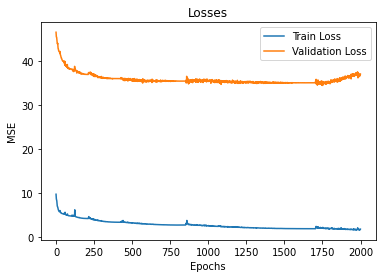

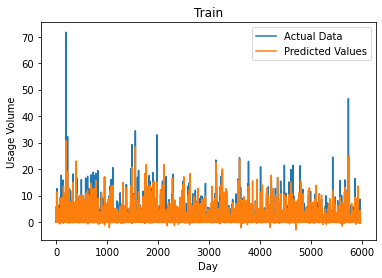

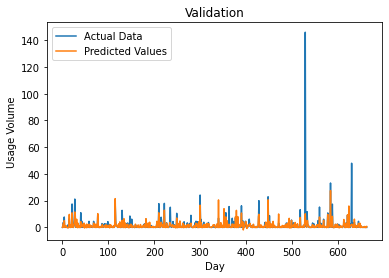

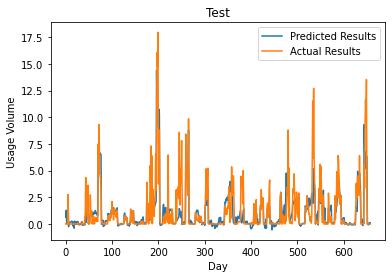

In [22]:
print('Test results:')
my_model.evaluate(x_val, y_val)

y_train_pred = my_model.predict(x_train)
y_test_pred = my_model.predict(x_val)

%matplotlib inline

plt.figure()
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Losses')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.figure()
plt.plot(y_train)
plt.plot(y_train_pred)
plt.title('Train')
plt.legend(['Actual Data', 'Predicted Values'])
plt.xlabel('Day')
plt.ylabel('Usage Volume')

plt.figure()
plt.plot(y_val)
plt.plot(y_test_pred)
plt.title('Validation')
plt.legend(['Actual Data', 'Predicted Values'])
plt.xlabel('Day')
plt.ylabel('Usage Volume')

r2_train = r2_score(y_true=y_train, y_pred=y_train_pred)
print('\nR2 score for train:', r2_train)

r2_val = r2_score(y_true=y_val, y_pred=y_test_pred)
print('\nR2 score for validation:', r2_val)

final_df = None
for person in people:
    person_train = train_file.loc[person]
    person_week1 = week1_file.loc[person]
    person_week2 = week2_file.loc[person]
    days = person_week2.shape[0]
    person_data = pd.concat([person_train, person_week1, person_week2]).drop('day', axis=1).values
    data_dim = person_data.shape
    for i in range(data_dim[0]):
        for j in range(data_dim[1]):
            if np.isnan(person_data[i, j]):
                person_data[i, j] = np.nanmean(person_data[:, j])
    for i in reversed(range(days)):
        if i == 0:
            sequence = person_data.copy()
        else:
            sequence = person_data.copy()[:-i]
        sequence[:, -1] = np.roll(sequence[:, -1], 1, axis=0)
        x = (sequence[1:] - x_min) / (x_max - x_min)
        person_data[-i-1, -1] = float(my_model.predict(x[np.newaxis, :, :]))
    final_person_data = person_data[-days:, -1]
    person_week2.reset_index(level=0, inplace=True)
    person_week2['data_usage_volume'] = final_person_data
    person_df = person_week2[['day', 'subscriber_ecid', 'data_usage_volume']]
    if final_df is None:
        final_df = person_df
    else:
        final_df = pd.concat([final_df, person_df])

pred = final_df['data_usage_volume'].values

actual = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_test_week2_with_target.csv')['data_usage_volume'].values

r2_test = r2_score(y_true=actual, y_pred=pred)
print('\nR2 score for test:', r2_test)

plt.figure()
plt.plot(pred)
plt.plot(actual)
plt.title('Test')
plt.xlabel('Day')
plt.ylabel('Usage Volume')
plt.legend(['Predicted Results', 'Actual Results'])

## Final results and creating the file

In [33]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

path = './My Model'

x_min = np.load(path + '/x_min.npy')
x_max = np.load(path + '/x_max.npy')

my_model = load_model(path)


train_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_train.csv', index_col='subscriber_ecid')
train_file.insert(train_file.shape[1] - 1, 'data_usage_volume', train_file.pop('data_usage_volume'))

week1_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_test_week1_with_target.csv', index_col='subscriber_ecid')
week1_file.insert(week1_file.shape[1] - 1, 'data_usage_volume', week1_file.pop('data_usage_volume'))

week2_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_test_week2_with_target.csv', index_col='subscriber_ecid')
week2_file.insert(week2_file.shape[1] - 1, 'data_usage_volume', week2_file.pop('data_usage_volume'))

week3_file = pd.read_csv('./MCI-RD-aaic-UIUF/MCIRD_aaic2021_test_week3.csv', index_col='subscriber_ecid')
week3_file.insert(week3_file.shape[1], 'data_usage_volume', np.zeros(week3_file.shape[0]))

people = np.unique(week3_file.index)

final_df = None
for person in people:
    person_train = train_file.loc[person]
    person_week1 = week1_file.loc[person]
    person_week2 = week2_file.loc[person]
    person_week3 = week3_file.loc[person]
    days = person_week3.shape[0]
    person_data = pd.concat([person_train, person_week1, person_week2, person_week3]).drop('day', axis=1).values
    data_dim = person_data.shape
    for i in range(data_dim[0]):
        for j in range(data_dim[1]):
            if np.isnan(person_data[i, j]):
                person_data[i, j] = np.nanmean(person_data[:, j])
    for i in reversed(range(days)):
        if i == 0:
            sequence = person_data.copy()
        else:
            sequence = person_data.copy()[:-i]
        sequence[:, -1] = np.roll(sequence[:, -1], 1, axis=0)
        x = (sequence[1:] - x_min) / (x_max - x_min)
        person_data[-i-1, -1] = float(my_model.predict(x[np.newaxis, :, :]))
    final_person_data = person_data[-days:, -1]
    person_week3.reset_index(level=0, inplace=True)
    person_week3['data_usage_volume'] = final_person_data
    person_df = person_week3[['day', 'subscriber_ecid', 'data_usage_volume']]
    if final_df is None:
        final_df = person_df
    else:
        final_df = pd.concat([final_df, person_df])

final_df.to_csv('./week3_results.csv', index=False)

<ipython-input-33-cd2b3e486057>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_week3['data_usage_volume'] = final_person_data
